# 1. Install PIP's

In [2]:
%pip install unidecode
%pip install spacy
%pip install seaborn
%pip install nltk
%pip install stats
%pip install xgboost
%pip install sweetviz
%pip install string
%pip install imblearn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement string (from versions: none)
ERROR: No matching distribution found for string


Note: you may need to restart the kernel to use updated packages.


# 2. Import Packages

In [3]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import spacy
nlp = spacy.load('pt_core_news_lg')
import string
import regex as re
from unidecode import unidecode
from scipy import stats
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

# 3. Load Data

In [4]:
customers_df = pd.read_csv("olist_customers_dataset.csv")
geolocation_df = pd.read_csv("olist_geolocation_dataset.csv")
order_items_df = pd.read_csv("olist_order_items_dataset.csv")
order_payments_df = pd.read_csv("olist_order_payments_dataset.csv")
order_reviews_df = pd.read_csv("olist_order_reviews_dataset.csv")
orders_df = pd.read_csv("olist_orders_dataset.csv")
products_df = pd.read_csv("olist_products_dataset.csv")
sellers_df = pd.read_csv("olist_sellers_dataset.csv")
product_category_name_translation_df = pd.read_csv("product_category_name_translation.csv")

# 4. Data Wreangling

### 4.1. Merge Data

In [31]:
df = orders_df.merge(order_reviews_df, on='order_id')\
                   .merge(order_items_df, on='order_id')\
                   .merge(products_df, on='product_id')\
                   .merge(sellers_df, on='seller_id')\
                   .merge(geolocation_df, left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix')

### 4.2. Selected Columns Important

In [32]:
selected_columns = ['review_id', 'review_score', 'review_comment_title', 
                    'review_comment_message', 'review_creation_date', 
                    'review_answer_timestamp', 'product_id', 
                    'geolocation_lat', 'geolocation_lng','geolocation_state']

full_df = df.loc[:, selected_columns]

### 4.3. Conversion Columns Data in datetime

In [33]:
datetime_columns = ['review_creation_date', 'review_answer_timestamp']
full_df[datetime_columns] = full_df[datetime_columns].apply(pd.to_datetime)

### 4.4. Drop Duplicates

In [34]:
full_df = full_df.drop_duplicates(subset=['review_id'])

### 4.5. Drop NA

In [35]:
full_df = full_df.dropna(subset=['review_comment_message'])
full_df = full_df.dropna(subset=['review_score'])

### 4.6. Take all different 3

In [36]:
full_df = full_df[full_df['review_score'] != 3]

### 4.7. Merge Title with Message

In [37]:
full_df['review_comment_title'] = full_df['review_comment_title'].fillna('').astype(str)
full_df['text_sentiment'] = full_df['review_comment_title'].str.cat(full_df['review_comment_message'], sep=' ')

### 4.8. Drop NA Text Sentiment

In [38]:
full_df = full_df.dropna(subset=['text_sentiment'])

# 5. Data Processing

### 5.1. Conversion Column Message in Lower Case

In [39]:
def to_lower(text):
    return text.lower()

In [40]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(to_lower)

### 5.2. Removing Punctuation, Exemple (".", "!")

In [41]:
def remove_punctuation(text):
    punct = string.punctuation
    punct = punct.replace("'", "")
    translator = str.maketrans('', '', punct)
    return text.translate(translator)

In [42]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(remove_punctuation)

### 5.3. Removing Emoji

In [43]:
def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # simbol and pictogramas
                               u"\U0001F680-\U0001F6FF"  # transport and ]simbol of map
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [44]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(remove_emojis)

### 5.4. Removing Sites and Blogs

In [45]:
def remove_urls(text):
    http = r"http\S+|www\.\S+"
    pattern = re.compile(r"({})".format(http))
    return pattern.sub(r'', text)

In [46]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(remove_urls)

### 5.5. Removing Accentuation

In [47]:
def remove_accent(text):
    return unidecode(text)

In [48]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(remove_accent)

### 5.6. Remove Numbers

In [49]:
def remove_numbers(texto):
    return re.sub(r'\d+', '', texto)

In [50]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(remove_numbers)

### 5.7. Remove Space Blank Excessive and Remove Broke Line

In [51]:
def remove_broke_line(texto):
    return texto.replace('\n', ' ')

In [52]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(remove_broke_line)

### 5.8. Remove Blank Space Text

In [53]:
def strip_text(text):
    return text.strip()

In [54]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(strip_text)

### 5.9. Filter only Adjetivos, Verbos, Substantivo, Adverbios and "nao" "nada"

In [55]:
def filtrar_tokens(text):
    doc = nlp(text)
    tokens_filtrados = []
    for token in doc:
        if token.text.lower() == 'nao':
            tokens_filtrados.append(token.text)
        elif token.text.lower() == 'nada':
            tokens_filtrados.append(token.text)
        elif token.pos_ in ['ADJ', 'VERB', 'NOUN', 'ADV']:
            tokens_filtrados.append(token.text)
    return ' '.join(tokens_filtrados)

In [56]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(filtrar_tokens)

### 5.10. Lematization

In [57]:
def lemmatize_text(text):
    return " ".join([token.lemma_ for token in nlp(text)])

In [58]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(lemmatize_text)

### 5.11. Remove the word "Produto"

In [59]:
def remove_word(text, word):
    return text.replace(word, '')

In [60]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(lambda x: remove_word(x, 'produto'))

In [61]:
full_df.head(5)

,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_id,geolocation_lat,geolocation_lng,geolocation_state,text_sentiment
0,a54f0611adc9ed256b57ede6b6eb5114,4,,"Não testei o produto ainda, mas ele veio corre...",2017-10-11,2017-10-12 03:43:48,87285b34884572647811a353c7ac498a,-23.680114,-46.452454,SP,nao testar ainda vir correto bom condicoes ap...
207,8d5266042046a06655c8db133d120ba5,4,Muito boa a loja,Muito bom o produto.,2018-08-08,2018-08-08 18:37:50,595fac2a385ac33a80bd5114aec74eb8,-19.810119,-43.984727,MG,muito bom loja muito bom
448,359d03e676b3c069f62cadba8dd3f6e8,5,,O produto foi exatamente o que eu esperava e e...,2017-12-03,2017-12-05 19:21:58,d0b61bfb1de832b15ba9d266ca96e5b0,-19.840168,-43.923299,MG,exatamente esperar descrito site chegar bem a...
620,e07549ef5311abcc92ba1784b093fb56,2,,fiquei triste por n ter me atendido.,2017-05-13,2017-05-13 20:25:42,a1804276d9941ac0733cfd409f5206eb,-23.536892,-46.713111,SP,fiquei triste n atendir
1468,15898b543726a832d4137fbef5d1d00e,1,,Aguardando retorno da loja,2017-05-30,2017-05-30 23:13:47,08574b074924071f4e201e151b152b4e,-20.297537,-40.400869,ES,aguardar retorno lojar


# 6. Previus Analyze

In [62]:
def df_metadata(df):
    metadata = pd.DataFrame(df.dtypes,columns=['dtypes'])
    metadata = metadata.reset_index()
    metadata['Column'] = metadata['index']
    metadata = metadata[['Column','dtypes']]
    metadata['# Missing'] = df.isnull().sum().values    
    metadata['# Unique'] = df.nunique().values
    metadata['Example'] = df.loc[0].values

    for name in metadata['Column'].value_counts().index:
        metadata.loc[metadata['Column'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return metadata
    
df_metadata(full_df)

,Column,dtypes,# Missing,# Unique,Example,Entropy
0,review_id,object,0,36599,a54f0611adc9ed256b57ede6b6eb5114,15.16
1,review_score,int64,0,4,4,1.61
2,review_comment_title,object,0,3721,,3.23
3,review_comment_message,object,0,32442,"Não testei o produto ainda, mas ele veio corre...",14.65
4,review_creation_date,datetime64[ns],0,617,2017-10-11 00:00:00,8.78
5,review_answer_timestamp,datetime64[ns],0,36578,2017-10-12 03:43:48,15.16
6,product_id,object,0,16941,87285b34884572647811a353c7ac498a,13.13
7,geolocation_lat,float64,0,1869,-23.680114,8.84
8,geolocation_lng,float64,0,1869,-46.452454,8.84
9,geolocation_state,object,0,20,SP,1.68


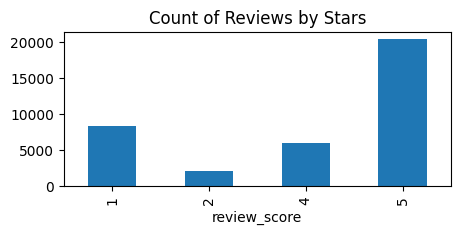

In [63]:
ax = full_df['review_score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(5,2))

In [64]:
example = full_df['text_sentiment'].iloc[4]
print(example)

aguardar retorno lojar


# 7. Training Model

### 7.1. Separeting Dataframe Training and Dataframe Test After Training

In [65]:
# Amostra os dados para df_train
df_train = full_df.sample(frac=0.99, random_state=45, ignore_index=True)

# Seleciona as linhas que não estão presentes em df_train para df_remaining
df_remaining = full_df.loc[~full_df.index.isin(df_train.index)].reset_index(drop=True)

### 7.2. Classifier Review Score Negative with 0 (Review 1 or 2) and Positive with 1 (Review 3,4 or 5)

In [66]:
df_train['sentiment'] = df_train['review_score'].apply(lambda x: 0 if x in [1,2] else 1)

In [67]:
df_train.head(5)

,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_id,geolocation_lat,geolocation_lng,geolocation_state,text_sentiment,sentiment
0,6317d5f77838b3b03565fe151a155529,5,super recomendo,produto otimo,2018-05-29,2018-05-29 19:44:17,36e11e6e23d31fb19391c75b1ed80a9a,-23.586208,-46.535891,SP,super recomendo otimo,1
1,021e56fd38eca114ba4694123a3c99ab,5,,Super recomendo a loja chegou além do prazo pr...,2018-02-08,2018-02-08 23:17:40,2b4609f8948be18874494203496bc318,-23.665703,-46.518082,SP,super recomendar loja chegar alem prazo prever...,1
2,0a9f2c9e4fffb9eb02ce82cd1fab61ab,5,,Relógio bonito. Entrega no prazo. Só não enten...,2017-12-19,2017-12-19 12:11:50,d8f254be723da6488610b42935533b05,-23.651115,-46.755211,SP,relogio bonito entregar prazo nao entender fre...,1
3,3664129b0b108f80ebd12dacd01f8ebf,5,,"A mochila é boa,o zíper agarra um pouco mais é...",2017-05-24,2017-05-25 02:54:02,786733d317255508bd4d648585977611,-23.207064,-46.760735,SP,mochila boao ziper agarrar pouco mais causa ma...,1
4,b629d402fbfaa8e2bbd1b6c33b656905,1,,As franjas são curtas e o Cabo não para estica...,2017-07-08,2017-07-15 01:51:15,dbb4ce89c8ed5fb6fd901e2e51093179,-23.528716,-46.620265,SP,franjas curto cabo nao esticar apertar rosca p...,0


### 7.3. Selecting Columns Necessary for Training

In [68]:
selected_columns = ['text_sentiment', 'sentiment']
df_classification = df_train.loc[:, selected_columns]

In [69]:
df_classification.head(5)

,text_sentiment,sentiment
0,super recomendo otimo,1
1,super recomendar loja chegar alem prazo prever...,1
2,relogio bonito entregar prazo nao entender fre...,1
3,mochila boao ziper agarrar pouco mais causa ma...,1
4,franjas curto cabo nao esticar apertar rosca p...,0


### 7.4. Divising Dataframe Between Train and Test

In [70]:
comment_train, comment_test, sentiment_train, sentiment_test = train_test_split(
                                                                                df_classification['text_sentiment'],
                                                                                df_classification['sentiment'], 
                                                                                test_size=0.2,
                                                                                random_state=24)

### 7.5. Inicializing Training IA

In [71]:
vectorizer = TfidfVectorizer()

In [72]:
ctmTr = vectorizer.fit_transform(comment_train)
comment_test_dtm = vectorizer.transform(comment_test)

In [73]:
smote = SMOTE(random_state=42)
ctmTr_resampled, sentiment_train_resampled = smote.fit_resample(ctmTr, sentiment_train)

In [74]:
normalization = preprocessing.StandardScaler(with_mean=False)

In [75]:
normalization.fit(ctmTr_resampled)
X = normalization.transform(ctmTr_resampled)

In [76]:
analyze_sentiment = MLPClassifier(hidden_layer_sizes=(32,16,16,1),
                                   activation='relu',
                                   solver='adam',
                                   learning_rate='constant',
                                   max_iter=1000,
                                   early_stopping=True,
                                   n_iter_no_change=25,
                                   verbose=True)

history = analyze_sentiment.fit(X, sentiment_train_resampled)

Iteration 1, loss = 0.42572449
Validation score: 0.927128
Iteration 2, loss = 0.27876807
Validation score: 0.933622
Iteration 3, loss = 0.23888503
Validation score: 0.935786
Iteration 4, loss = 0.21231354
Validation score: 0.938913
Iteration 5, loss = 0.19219778
Validation score: 0.940356
Iteration 6, loss = 0.17524376
Validation score: 0.939153
Iteration 7, loss = 0.16226147
Validation score: 0.935546
Iteration 8, loss = 0.15042790
Validation score: 0.945647
Iteration 9, loss = 0.14118700
Validation score: 0.942761
Iteration 10, loss = 0.13398741
Validation score: 0.942520
Iteration 11, loss = 0.12792896
Validation score: 0.943482
Iteration 12, loss = 0.12221931
Validation score: 0.942761
Iteration 13, loss = 0.11755334
Validation score: 0.942039
Iteration 14, loss = 0.11354295
Validation score: 0.942280
Iteration 15, loss = 0.11106727
Validation score: 0.942039
Iteration 16, loss = 0.10820210
Validation score: 0.941799
Iteration 17, loss = 0.10695228
Validation score: 0.941799
Iterat

# 8. Analyze Performance IA

### 8.1. Score

In [91]:
X_test = normalization.transform(comment_test_dtm)
analyze_sentiment.score(X_test,sentiment_test)

0.8922312681109424

In [96]:
# Extrair o vocabulário (palavras) e suas contagens
palavras = vectorizer.get_feature_names_out()
contagem_palavras = ctmTr.toarray().sum(axis=0)

# Criar um DataFrame com as palavras mais comuns e suas contagens
top_palavras = pd.DataFrame({'Palavra': palavras, 'Contagem': contagem_palavras})
top_palavras = top_palavras.sort_values(by='Contagem', ascending=False).reset_index(drop=True)

# Exibir as 20 palavras mais comuns com uma tabela colorida
top_palavras_estilizado = top_palavras.head(20).style.background_gradient(cmap='Blues')

# Exibir o DataFrame estilizado e as 20 palavras mais comuns
display(top_palavras_estilizado)

,Palavra,Contagem
0,bom,1874.142933
1,entregar,1747.150119
2,muito,1657.223329
3,prazo,1544.180237
4,nao,1323.345071
5,antes,1216.478182
6,otimo,1175.795501
7,chegar,1139.196911
8,recomendar,908.489095
9,recebi,817.074590


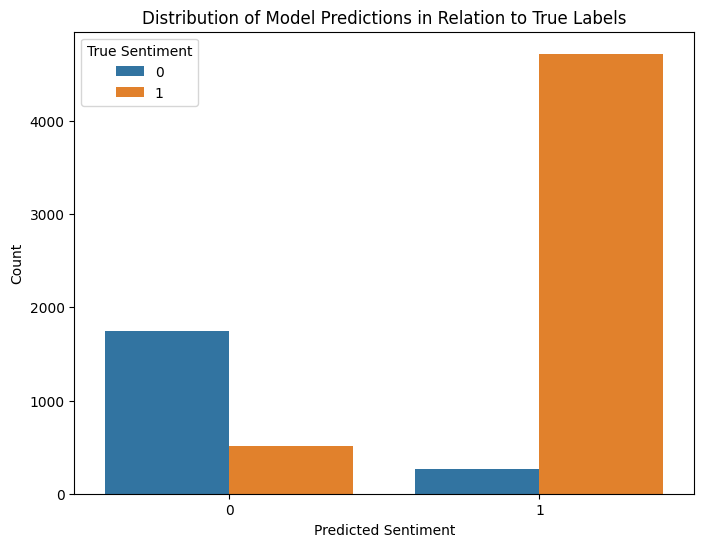

In [100]:
predictions = analyze_sentiment.predict(X_test)

predictions_df = pd.DataFrame({
    'True Sentiment': sentiment_test,
    'Predicted Sentiment': predictions
})

# 3. Plote a distribuição das previsões para cada classe
plt.figure(figsize=(8, 6))
sns.countplot(x='Predicted Sentiment', hue='True Sentiment', data=predictions_df)
plt.title('Distribution of Model Predictions in Relation to True Labels')
plt.xlabel('Predicted Sentiment')
plt.ylabel('Count')
plt.legend(title='True Sentiment')
plt.show()

### 8.2. Graph Loss and Score During Training

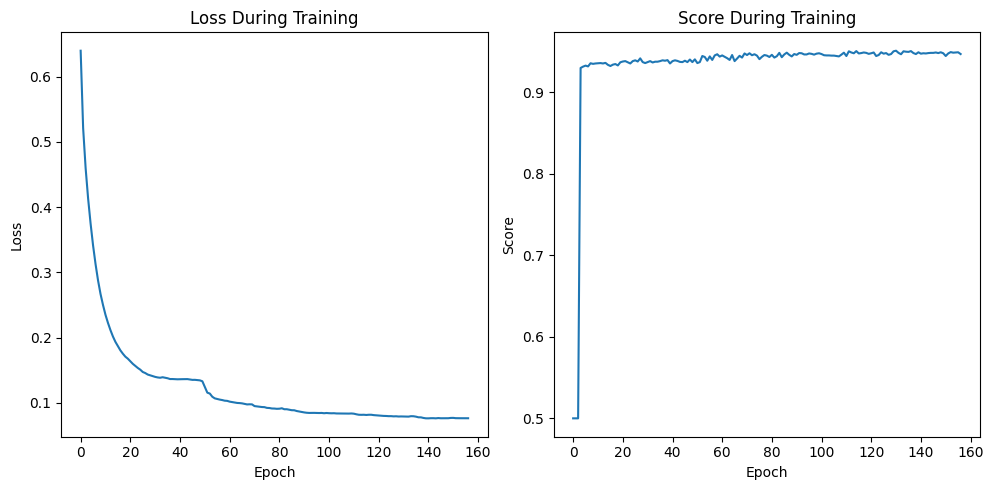

In [ ]:
plt.figure(figsize=(10, 5))
# Loss
plt.subplot(1, 2, 1)
plt.plot(history.loss_curve_)
plt.title('Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.validation_scores_)
plt.title('Score During Training')
plt.xlabel('Epoch')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

### 8.3. Confusion Matrix

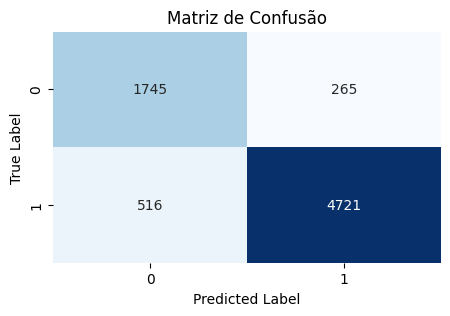

In [99]:
predictions = analyze_sentiment.predict(X_test)
conf_matrix = confusion_matrix(sentiment_test, predictions)
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusão')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### 8.4. Curve ROC

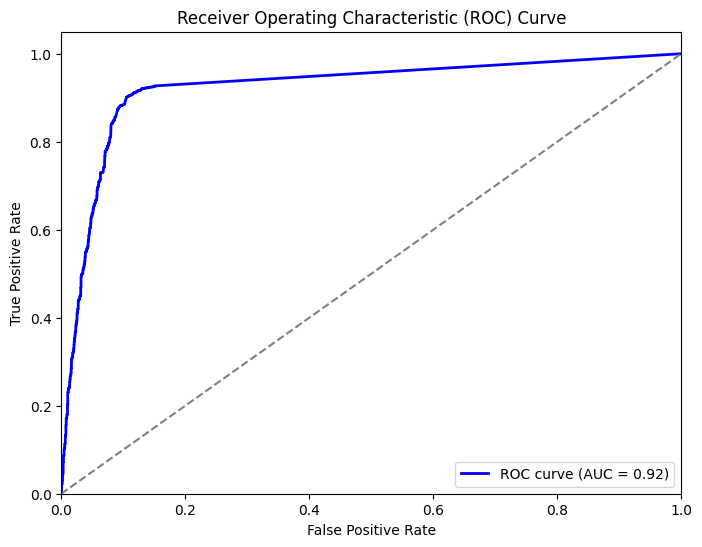

In [ ]:
probas_pred = analyze_sentiment.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(sentiment_test, probas_pred)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# 9. Test and Deploy IA

In [101]:
# Ajustar configurações para mostrar o texto completo
pd.set_option('display.max_colwidth', None)

texto_teste_vetorizado = vectorizer.transform(df_remaining['review_comment_message'])
texto_teste_normalizado = normalization.transform(texto_teste_vetorizado)
sentimento_predito = analyze_sentiment.predict(texto_teste_normalizado)

df_remaining['sentimento_predito'] = sentimento_predito

df_remaining['sentimento_predito'] = df_remaining['sentimento_predito'].replace({0: 'negativo', 1: 'positivo'})

display(df_remaining[['text_sentiment', 'review_score', 'sentimento_predito']])

df_remaining[['review_id','review_comment_message','text_sentiment', 'review_score', 'sentimento_predito']].to_csv('dados_processados.csv', index=False)


,text_sentiment,review_score,sentimento_predito
0,nao testar ainda vir correto bom condicoes apenas caixa vir bem amassar danificar ficar chato tratar presente,4,positivo
207,muito bom loja muito bom,4,positivo
448,exatamente esperar descrito site chegar bem antes data prever,5,positivo
620,fiquei triste n atendir,2,negativo
1468,aguardar retorno lojar,1,negativo
...,...,...,...
16233547,otimar comprar site mercadoria chegar antes prazo determinar,5,positivo
16233702,nao mini Cajon Shaker Chocalho imitar cajon pessimo,1,negativo
16234495,so pecar vir rachar bem rs,4,positivo
16234587,entregar antes prazo,5,positivo


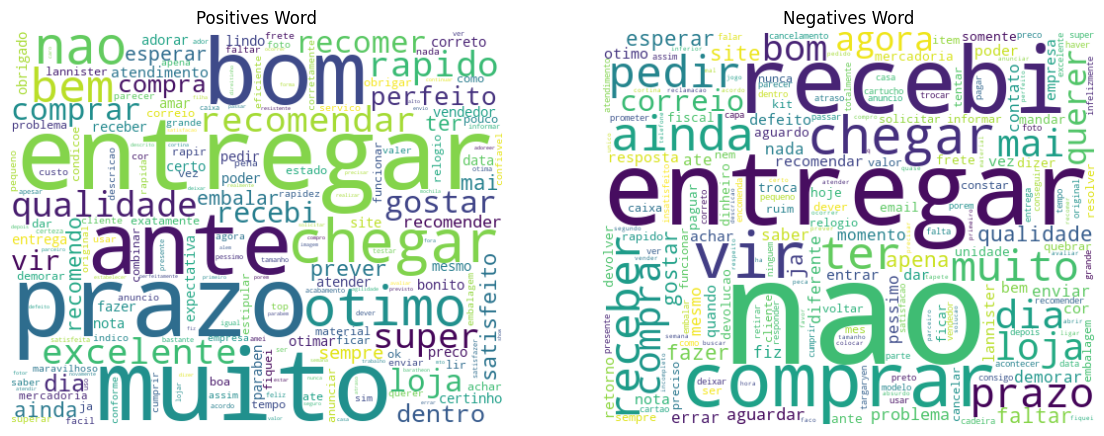

In [ ]:
# Juntar todas as palavras dos textos mais positivos e mais negativos
Most_Positive_text = ' '.join(df_remaining[df_remaining['sentimento_predito'] == 'positivo']['text_sentiment'])
Most_Negative_text = ' '.join(df_remaining[df_remaining['sentimento_predito'] == 'negativo']['text_sentiment'])

# Criar as nuvens de palavras
pwc = WordCloud(width=500, height=400, collocations=False, background_color='white').generate(Most_Positive_text)
nwc = WordCloud(width=500, height=400, collocations=False, background_color='white').generate(Most_Negative_text)

# Plotar as nuvens de palavras
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.imshow(pwc, interpolation='bilinear')
plt.title('Positives Word', fontsize=12)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(nwc, interpolation='bilinear')
plt.title('Negatives Word', fontsize=12)
plt.axis('off')

plt.show()

In [82]:
# Filtrar mensagens positivas e negativas
mensagens_positivas = full_df[full_df['sentimento_predito'] == 'positivo']['text_sentiment']
mensagens_negativas = full_df[full_df['sentimento_predito'] == 'negativo']['text_sentiment']

def contar_palavras(mensagens, sentiment):
    todas_mensagens = ' '.join(mensagens)
    palavras = todas_mensagens.split()
    contagem_palavras = Counter(palavras)
    
    # Criando o DataFrame
    df_contagem = pd.DataFrame(contagem_palavras.most_common(60), columns=['word', 'count'])
    df_contagem['sentiment'] = sentiment
    return df_contagem

# Contar palavras mais comuns para mensagens positivas
df_positivas = contar_palavras(mensagens_positivas, 'positivo')

# Contar palavras mais comuns para mensagens negativas
df_negativas = contar_palavras(mensagens_negativas, 'negativo')

# Concatenar os DataFrames
df_final = pd.concat([df_positivas, df_negativas])

### Export Model in .pkl

In [86]:
with open('modelo_analyze_sentiment.pkl', 'wb') as arquivo:
    pickle.dump(analyze_sentiment, arquivo)